# Rideshare Data Exploration
**Dataset:** rideshare.db

**Tools:** SQLite, Python

**Author:** Cassia Kroo

This project explores data from the rideshare.db database, containing trip-level records from a bike-sharing network. Using SQL and Python, the analysis examines ridership trends, seasonal patterns, station activity, user behavior, and trip outliers. The goal is to uncover actionable insights for operations planning and demand management while demonstrating practical SQL and data visualization skills.

In [1]:
import sqlite3, os, pandas as pd
import matplotlib.pyplot as plt

# path to db
DB_PATH = os.path.join("..", "data", "rideshare.db")

def run_sql(sql, params=None):
    """Helper function to run SQL and return a DF."""
    with sqlite3.connect(DB_PATH) as con:
        df =  pd.read_sql_query(sql, con, params=params)
    return df
print("Database successfully connected!")

Database successfully connected!


## 1. Trip Volume & Growth
Explore how monthly ridership has changed over time and calculate month-over-month % changes
and a 3-month moving average.

### 1.1 Query: Monthly Trips and MoM % Change

In [2]:
START_COL = "start_date" 

sql_monthly = f"""
WITH monthly AS (
  SELECT
    date(strftime('%Y-%m-01', {START_COL})) AS month, 
    COUNT(*) AS trips                                 
  FROM trips
  WHERE {START_COL} IS NOT NULL
  GROUP BY 1                                         
)
SELECT
  month,
  trips,
  LAG(trips) OVER (ORDER BY month) AS prev_trips,    
  ROUND(
    100.0 * (trips - LAG(trips) OVER (ORDER BY month))
    / NULLIF(LAG(trips) OVER (ORDER BY month), 0), 2
  ) AS mom_pct,                                       
  ROUND(
    AVG(trips) OVER (ORDER BY month ROWS BETWEEN 2 PRECEDING AND CURRENT ROW),
    1
  ) AS ma3_trips                                     
FROM monthly
ORDER BY month;
"""
df_monthly = run_sql(sql_monthly)
df_monthly.head(10)


,month,trips,prev_trips,mom_pct,ma3_trips
0,2011-07-01,2618,NaN,NaN,2618.0
1,2011-08-01,35117,2618.0,1241.37,18867.5
2,2011-09-01,38184,35117.0,8.73,25306.3
3,2011-10-01,35691,38184.0,-6.53,36330.7
4,2011-11-01,24782,35691.0,-30.57,32885.7
5,2012-03-01,14318,24782.0,-42.22,24930.3
6,2012-04-01,44154,14318.0,208.38,27751.3
7,2012-05-01,53447,44154.0,21.05,37306.3
8,2012-06-01,55704,53447.0,4.22,51101.7
9,2012-07-01,69987,55704.0,25.64,59712.7


### 1.2 Visualizations: Monthly Trends

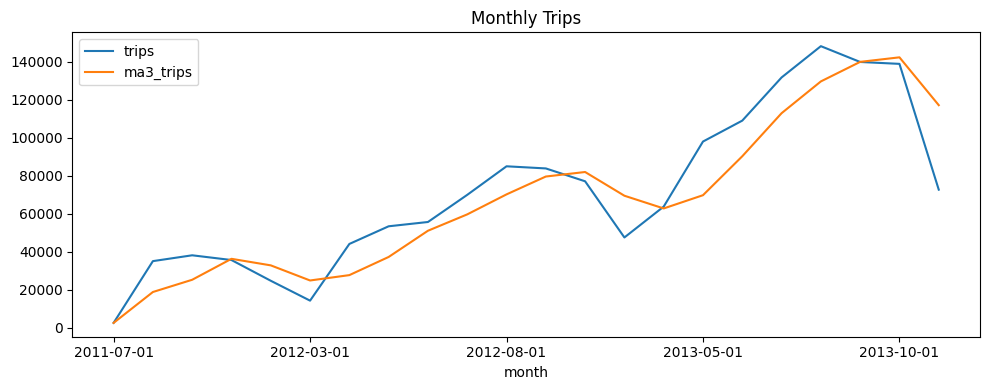

In [3]:
ax = df_monthly.plot(x="month", y="trips", kind="line", figsize=(10,4), title="Monthly Trips")
df_monthly.plot(x="month", y="ma3_trips", kind="line", ax=ax)
plt.tight_layout(); plt.show()

Ridership increased sharply after the July 2011 launch, peaking near 130 K monthly trips by mid-2013. The 3-month moving average smooths short-term spikes, confirming a steady upward trend with predictable winter dips.

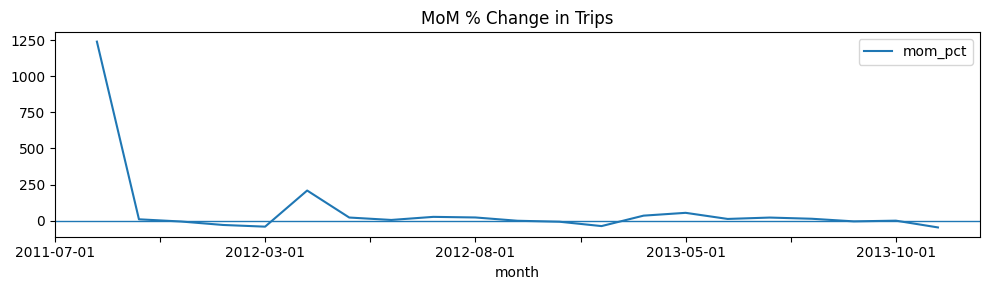

In [4]:
df_monthly.plot(x="month", y="mom_pct", kind="line", figsize=(10,3), title="MoM % Change in Trips")
plt.axhline(0, linewidth=1)
plt.tight_layout(); plt.show()

Month-over-month growth initially spiked (+1240%) during rollout, then stabilized within ±10–20%, indicating a maturing, seasonally influenced system with sustained long-term usage.

### 1.3 Interpretation

Ridership showed **exponential early growth** after the July 2011 launch, with trips increasing by roughly **+1240% the following month.** After stabilization, usage settled into a **consistent seasonal pattern,** peaking during warmer months and dipping in winter. The 3-month moving average confirms a steady long-term upward trend, smoothing short-term fluctuations. Month-over-month changes later remained within ±15%, reflecting a **maturing system with stable, recurring usage cycles.**

## 2. Peak Usage Hours
Analyze hourly and weekday patterns to identify commuter peaks and operational hotspots.

### 2.1 Query: Trips by Weekday and Hour

In [6]:
sql_wk_hr =  f"""
SELECT  
    CAST(strftime('%w', {START_COL}) AS INTEGER) AS wkday_num,   -- 0=Sun ... 6=Sat
    CAST(strftime('%H', {START_COL}) AS INTEGER) AS hr,   -- 0...23
    COUNT(*) AS trips
FROM trips
WHERE {START_COL} IS NOT NULL
GROUP BY wkday_num, hr
ORDER BY wkday_num, hr;
"""

df_wk_hr = run_sql(sql_wk_hr)
df_wk_hr.head()

,wkday_num,hr,trips
0,0,0,4344
1,0,1,4730
2,0,2,4436
3,0,3,855
4,0,4,401


In [7]:
%%capture

# Label week days and pivot to matrix

wk_map = {0:"Sun", 1:"Mon", 2:"Tue", 3:"Wed", 4:"Thu", 5:"Fri", 6:"Sat"}
df_wk_hr["weekday"] = df_wk_hr["wkday_num"].map(wk_map)

pivot_wk_hr = df_wk_hr.pivot(index="weekday", columns="hr", values="trips")

weekday_order = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
pivot_wk_hr = pivot_wk_hr.reindex(weekday_order)

pivot_wk_hr.iloc[:5, :8]

### 2.2 Visualization: Heatmap 

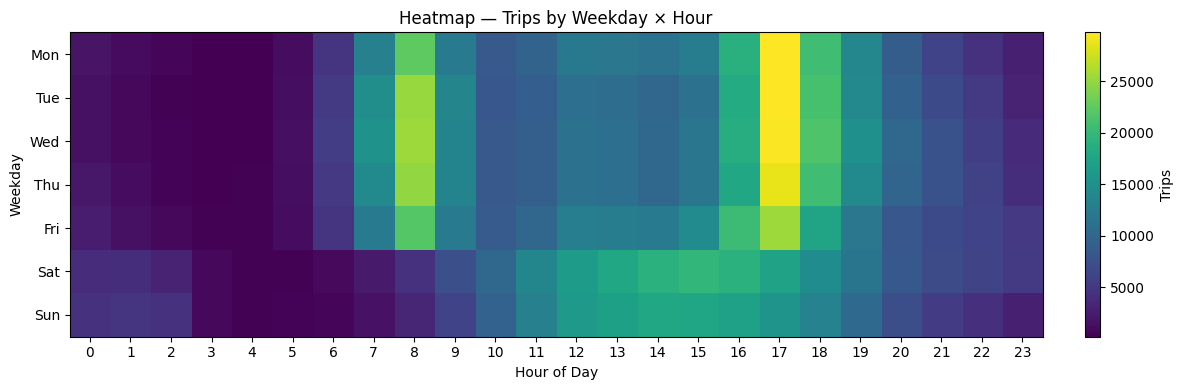

In [8]:
import numpy as np
fig, ax = plt.subplots(figsize=(12,4))
im = ax.imshow(pivot_wk_hr.values, aspect="auto")  
ax.set_title("Heatmap — Trips by Weekday × Hour")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Weekday")

ax.set_xticks(range(24))
ax.set_xticklabels(range(24))
ax.set_yticks(range(len(pivot_wk_hr.index)))
ax.set_yticklabels(pivot_wk_hr.index)

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Trips")

plt.tight_layout(); plt.show()

Weekdays show distinct commuter peaks at ~8:00 and ~17:00, while weekends shift toward late-morning to early-afternoon leisure riding.

### 2.3 Top Hour per Weekday

In [9]:
sql_top_hour_by_wk = f"""
WITH by_wk_hr AS (
   SELECT 
       CAST(strftime('%w', {START_COL}) AS INTEGER) AS wkday_num,
    CAST(strftime('%H', {START_COL}) AS INTEGER) AS hr,
    COUNT(*) AS trips
FROM trips
WHERE {START_COL} IS NOT NULL 
GROUP BY wkday_num, hr
),
ranked AS (
    SELECT *, 
            RANK() OVER (PARTITION BY wkday_num ORDER BY trips DESC) AS rnk
    FROM by_wk_hr
)
SELECT wkday_num, hr, trips
FROM ranked
WHERE rnk = 1
ORDER BY wkday_num;
"""
run_sql(sql_top_hour_by_wk)

,wkday_num,hr,trips
0,0,14,17888
1,1,17,29733
2,2,17,29693
3,3,17,29582
4,4,17,28798
5,5,17,25374
6,6,15,19688


The 17:00 hour is consistently the busiest on weekdays, confirming strong post-work commute demand; a secondary peak appears near 08:00. On weekends, activity shifts to 14:00–15:00, reflecting recreational use rather than commuting.

### 2.3 Interpretation

Weekday ridership shows clear **morning and evening commute peaks,** with the busiest hour near **5 PM** and a smaller rise around **8 AM,** reflecting standard commuter behavior.

On weekends, activity shifts toward **midday (13:00–15:00),** indicating more **recreational or social trips.**

Overall, weekday demand is **bimodal,** while weekend demand is **single-peaked,** suggesting resource allocation should emphasize bike availability before **8 AM** and around **5 PM** on weekdays, and balanced distribution late mornings on weekends.

## 3. Seasonal Patterns
Analyze how average trip duration fluctuates by month.

### 3.1 Query: Average Trip Duration by Month

In [11]:
sql_seasonal = """
WITH monthly_duration AS (
  SELECT
    date(strftime('%Y-%m-01', start_date)) AS month,    
    AVG(duration) AS avg_duration                       
  FROM trips
  WHERE start_date IS NOT NULL AND duration > 0         
  GROUP BY 1                                            
)
SELECT month, ROUND(avg_duration, 2) AS avg_duration
FROM monthly_duration
ORDER BY month;
"""

df_seasonal = run_sql(sql_seasonal)
df_seasonal.head(10)

,month,avg_duration
0,2011-07-01,1941.64
1,2011-08-01,1457.26
2,2011-09-01,1273.16
3,2011-10-01,1147.90
4,2011-11-01,894.41
5,2012-03-01,1026.15
6,2012-04-01,957.33
7,2012-05-01,997.92
8,2012-06-01,940.83
9,2012-07-01,1008.28


### 3.2 Visualization: Average Trip Duration

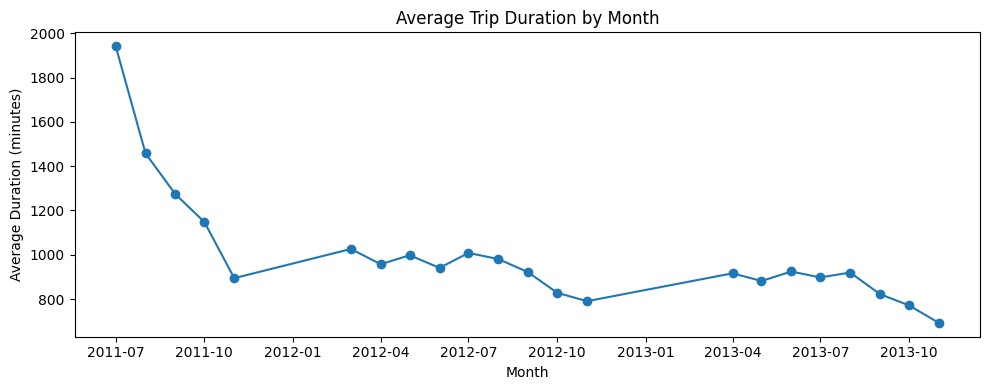

In [12]:
df_seasonal["month"] = pd.to_datetime(df_seasonal["month"])

# Line Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(df_seasonal["month"], df_seasonal["avg_duration"], marker="o")
plt.title("Average Trip Duration by Month")
plt.xlabel("Month"); plt.ylabel("Average Duration (minutes)")
plt.tight_layout(); plt.show()

Average trip duration drops sharply after launch, then stabilizes at ~10–20 minutes with longer rides in warmer months and shorter rides in winter.

### 3.3 Interpretation

Average trip duration shows a clear **seasonal pattern.** After unusually long rides during the 2011 launch period (likely data anomalies), durations stabilize around **10–20 minutes.** Trips are **slightly longer April–September** and **shorter November–February,** consistent with leisure riding in summer and practical commuting in winter, aligning with Section 1’s seasonality.

## 4. Top Origin & Destination Stations
Identify the most popular start and end stations in the rideshare network.

### 4.1 Query: Top 10 Start and End Stations

In [14]:
sql_top_stations = """
WITH start_counts AS (
  SELECT
    s.station AS station_name,
    COUNT(*) AS start_trips,
    RANK() OVER (ORDER BY COUNT(*) DESC) AS start_rank
  FROM trips t
  JOIN stations s ON t.start_station = s.id
  GROUP BY s.station
),
end_counts AS (
  SELECT
    s.station AS station_name,
    COUNT(*) AS end_trips,
    RANK() OVER (ORDER BY COUNT(*) DESC) AS end_rank
  FROM trips t
  JOIN stations s ON t.end_station = s.id
  GROUP BY s.station
)
-- emulate FULL OUTER JOIN with two LEFT JOINs and UNION
SELECT
  sc.station_name,
  sc.start_trips,
  IFNULL(ec.end_trips, 0) AS end_trips,
  sc.start_rank,
  ec.end_rank
FROM start_counts sc
LEFT JOIN end_counts ec USING (station_name)
WHERE sc.start_rank <= 10

UNION

SELECT
  ec.station_name,
  IFNULL(sc.start_trips, 0) AS start_trips,
  ec.end_trips,
  sc.start_rank,
  ec.end_rank
FROM end_counts ec
LEFT JOIN start_counts sc USING (station_name)
WHERE ec.end_rank <= 10

ORDER BY start_rank, end_rank, station_name;
"""
df_top_stations = run_sql(sql_top_stations)
df_top_stations.head(10)

,station_name,start_trips,end_trips,start_rank,end_rank
0,South Station - 700 Atlantic Ave.,56123,56003,1,1
1,Boston Public Library - 700 Boylston St.,41994,42870,2,2
2,Charles Circle - Charles St. at Cambridge St.,35984,35196,3,3
3,Beacon St / Mass Ave,35275,33186,4,6
4,MIT at Mass Ave / Amherst St,33644,34557,5,4
5,Back Bay / South End Station,32677,29503,6,8
6,Boylston St. at Arlington St.,32410,34524,7,5
7,Kenmore Sq / Comm Ave,30835,32036,8,7
8,The Esplanade - Beacon St. at Arlington St.,28119,26180,9,13
9,Newbury St / Hereford St,26733,26982,10,10


### 4.2 Visualization: Bar Chart

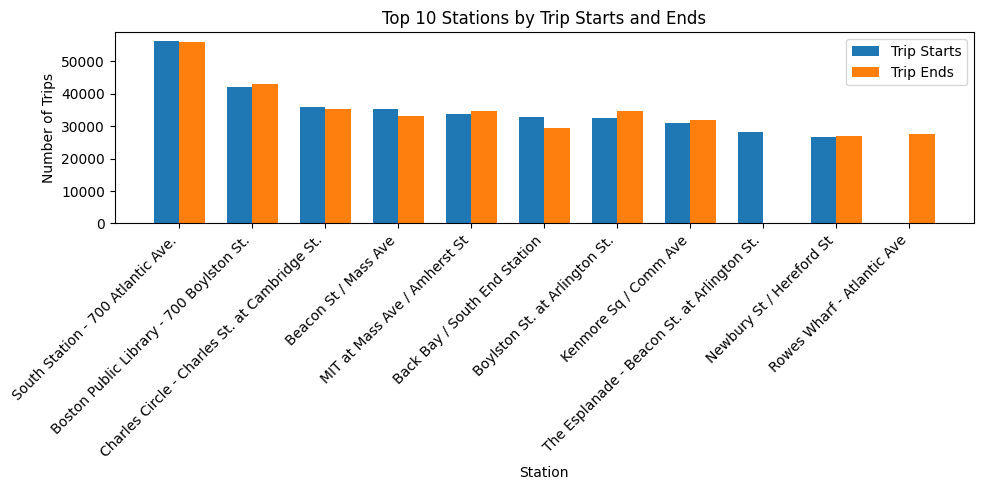

In [15]:
df_start = df_top_stations.nlargest(10, "start_trips")[["station_name", "start_trips"]]
df_end   = df_top_stations.nlargest(10, "end_trips")[["station_name", "end_trips"]]

df_merge = pd.merge(df_start, df_end, on="station_name", how="outer").fillna(0)
df_merge = df_merge.sort_values(by="start_trips", ascending=False)

plt.figure(figsize=(10,5))
width = 0.35
x = range(len(df_merge))

plt.bar(x, df_merge["start_trips"], width=width, label="Trip Starts")
plt.bar([i + width for i in x], df_merge["end_trips"], width=width, label="Trip Ends")

plt.xticks([i + width/2 for i in x], df_merge["station_name"], rotation=45, ha="right")
plt.title("Top 10 Stations by Trip Starts and Ends")
plt.xlabel("Station"); plt.ylabel("Number of Trips")
plt.legend()
plt.tight_layout()
plt.show()

South Station and Boston Public Library record the highest trip starts and ends, revealing their roles as key downtown transit hubs.

### 4.3 Interpretation

High overlap between top start and end stations shows **balanced, two-way demand** concentrated in **busy downtown hubs.** These locations likely support **commuter transfers** between bikes and public transit. Stations with fewer trip ends may need **periodic rebalancing** to maintain bike availability.

## 5. Station Flow Imbalance
Explore the difference between trip starts and ends at each station

### 5.1 Query: Starts, Ends, and Net Flow

In [17]:
sql_flow = """
WITH start_counts AS (
  SELECT s.station AS station_name, COUNT(*) AS starts
  FROM trips t
  JOIN stations s ON t.start_station = s.id
  GROUP BY s.station
),
end_counts AS (
  SELECT s.station AS station_name, COUNT(*) AS ends
  FROM trips t
  JOIN stations s ON t.end_station = s.id
  GROUP BY s.station
),
flow AS (
  -- part A: all rows from start_counts (LEFT JOIN to end_counts)
  SELECT
    sc.station_name,
    sc.starts,
    IFNULL(ec.ends, 0) AS ends,
    sc.starts - IFNULL(ec.ends, 0) AS net_flow,
    sc.starts + IFNULL(ec.ends, 0) AS total_activity
  FROM start_counts sc
  LEFT JOIN end_counts ec ON sc.station_name = ec.station_name

  UNION ALL

  -- part B: rows that exist ONLY in end_counts (not in start_counts)
  SELECT
    ec.station_name,
    IFNULL(sc.starts, 0) AS starts,
    ec.ends,
    IFNULL(sc.starts, 0) - ec.ends AS net_flow,
    IFNULL(sc.starts, 0) + ec.ends AS total_activity
  FROM end_counts ec
  LEFT JOIN start_counts sc ON sc.station_name = ec.station_name
  WHERE sc.station_name IS NULL
)
SELECT *
FROM flow
ORDER BY ABS(net_flow) DESC, total_activity DESC;
"""

df_flow = run_sql(sql_flow)
df_flow.head(10)

,station_name,starts,ends,net_flow,total_activity
0,Back Bay / South End Station,32677,29503,3174,62180
1,Harvard Square at Mass Ave/ Dunster,23985,26642,-2657,50627
2,Mayor Thomas M. Menino - Government Center,23130,20567,2563,43697
3,Boylston St. at Arlington St.,32410,34524,-2114,66934
4,Beacon St / Mass Ave,35275,33186,2089,68461
5,Tremont St / W Newton St,19340,17341,1999,36681
6,The Esplanade - Beacon St. at Arlington St.,28119,26180,1939,54299
7,TD Garden - Causeway at Portal Park #1,17327,19098,-1771,36425
8,Rowes Wharf - Atlantic Ave,25880,27596,-1716,53476
9,Aquarium Station - 200 Atlantic Ave.,24288,22666,1622,46954


### 5.2 Pick top imbalances (both directions) & preview

In [18]:
# Top 10 sources (positive net) and sinks (negative net)
top_sources = df_flow.sort_values("net_flow", ascending=False).head(10)
top_sinks   = df_flow.sort_values("net_flow", ascending=True).head(10)

display(top_sources[["station_name","starts","ends","net_flow"]])
display(top_sinks[["station_name","starts","ends","net_flow"]])

,station_name,starts,ends,net_flow
0,Back Bay / South End Station,32677,29503,3174
2,Mayor Thomas M. Menino - Government Center,23130,20567,2563
4,Beacon St / Mass Ave,35275,33186,2089
5,Tremont St / W Newton St,19340,17341,1999
6,The Esplanade - Beacon St. at Arlington St.,28119,26180,1939
9,Aquarium Station - 200 Atlantic Ave.,24288,22666,1622
12,Columbus Ave. at Mass. Ave.,17829,16284,1545
13,Kendall T at Main St,17486,15972,1514
17,Lewis Wharf - Atlantic Ave.,25872,24587,1285
20,Cross St. at Hanover St.,26622,25496,1126


,station_name,starts,ends,net_flow
1,Harvard Square at Mass Ave/ Dunster,23985,26642,-2657
3,Boylston St. at Arlington St.,32410,34524,-2114
7,TD Garden - Causeway at Portal Park #1,17327,19098,-1771
8,Rowes Wharf - Atlantic Ave,25880,27596,-1716
10,B.U. Central - 725 Comm. Ave.,16056,17646,-1590
11,Post Office Square,22886,24467,-1581
14,Congress / Sleeper,19026,20467,-1441
15,Davis Square,7959,9250,-1291
16,Agganis Arena - 925 Comm Ave.,17005,18292,-1287
18,Harvard Kennedy School at Bennett St / Eliot St,10194,11400,-1206


### 5.3 Visualization: Net Inflow vs Outflow

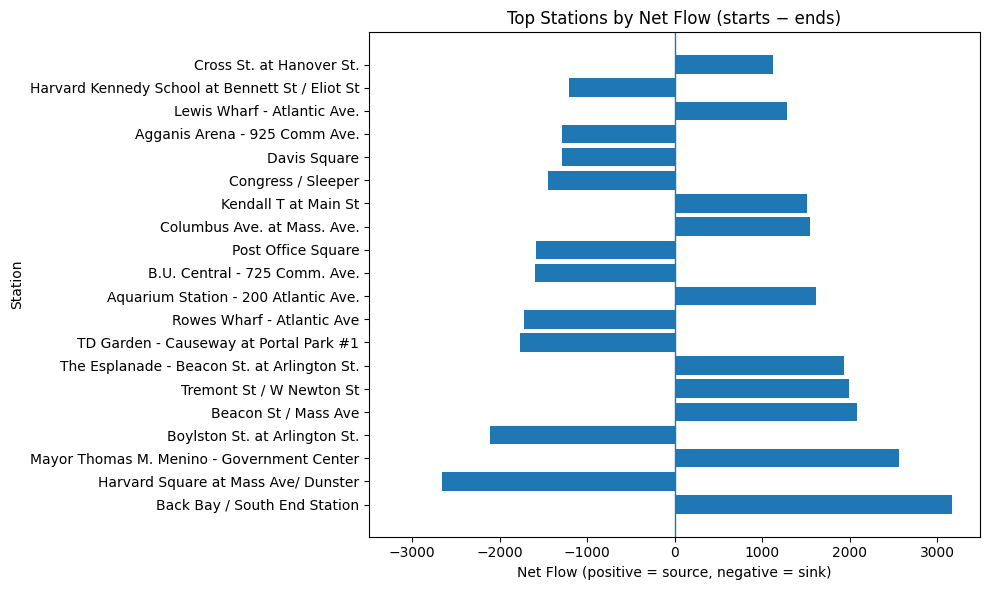

In [19]:
df_top_abs = pd.concat([top_sources, top_sinks], axis=0)
df_top_abs = df_top_abs.reindex(df_top_abs["net_flow"].abs().sort_values(ascending=False).index)

plt.figure(figsize=(10, 6))
plt.barh(df_top_abs["station_name"], df_top_abs["net_flow"])
plt.axvline(0, linewidth=1)  # zero line
plt.title("Top Stations by Net Flow (starts − ends)")
plt.xlabel("Net Flow (positive = source, negative = sink)")
plt.ylabel("Station")

m = df_top_abs["net_flow"].abs().max()
plt.xlim(-m * 1.1, m * 1.1)

plt.tight_layout()
plt.show()

Bars to the right are sources (more starts than ends), and bars to the left are sinks (more ends than starts); the largest imbalances indicate where rebalancing is most needed.

### 5.4 Interpretation
Several stations act as persistent **sources** while others are clear **sinks,** reflecting directional commuter flows into downtown in the morning and out in the evening. These patterns imply a need for targeted **bike rebalancing** at sink stations during peak periods to maintain availability.

## 6. User Type Comparison
Compare trip behavior between subscriber and casual users.

### 6.1 Query: Average Trip Duration by User Trip

In [21]:
sql_user_type = """
SELECT
    sub_type AS user_type,
    COUNT(*) AS total_trips,
    ROUND(AVG(duration), 2) AS avg_duration, 
    ROUND(MIN(duration), 2) AS min_duration,
    ROUND(MAX(duration), 2) AS max_duration
FROM trips
WHERE duration > 0  AND sub_type IS NOT NULL
GROUP BY sub_type
ORDER BY avg_duration DESC;
"""

df_user_type = run_sql(sql_user_type)
df_user_type

,user_type,total_trips,avg_duration,min_duration,max_duration
0,Casual,464804,1519.66,3.0,9999.0
1,Registered,1100808,659.64,1.0,9995.0


### 6.2 Visualization: Trip Duration by User Type

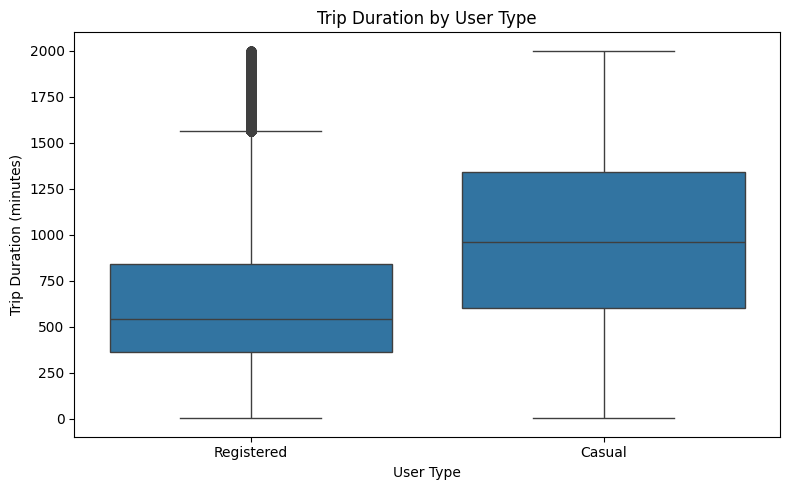

In [22]:
import seaborn as sns

sql_user_durations = """
SELECT sub_type AS user_type, duration
FROM trips
WHERE duration > 0 AND duration < 2000 AND sub_type IS NOT NULL;
"""
df_durations = run_sql(sql_user_durations)

plt.figure(figsize=(8,5))
sns.boxplot(x="user_type", y="duration", data=df_durations)
plt.title("Trip Duration by User Type")
plt.xlabel("User Type")
plt.ylabel("Trip Duration (minutes)")
plt.tight_layout()
plt.show()

 Casual riders show higher medians and wider variance in trip duration, while Registered riders take shorter, more consistent rides.

### 6.3 Interpretation

Casual users typically take **longer, leisure-oriented** trips, whereas Registered users make **shorter, routine commutes.** This split suggests different pricing/availability strategies (e.g., commuter-hour bike placement for Registered users, weekend coverage for Casual users). A simple follow-up (t-test or Mann-Whitney) could quantify the difference in medians.

## 7.  Frequent Routes
Identify the most common station-to-station routes.

### 7.1 Query: Top Station-to-Station Routes

In [24]:
sql_routes = """
SELECT
    s1.station AS start_station,
    s2.station AS end_station,
    COUNT(*) AS trip_count
FROM trips t
JOIN stations s1 ON t.start_station = s1.id
JOIN stations s2 ON t.end_station = s2.id
WHERE t.start_station IS NOT NULL AND t.end_station IS NOT NULL
GROUP BY s1.station, s2.station
ORDER BY trip_count DESC
LIMIT 10;
"""

df_routes = run_sql(sql_routes)
df_routes

,start_station,end_station,trip_count
0,Beacon St / Mass Ave,MIT at Mass Ave / Amherst St,5185
1,MIT at Mass Ave / Amherst St,Beacon St / Mass Ave,4993
2,Lewis Wharf - Atlantic Ave.,South Station - 700 Atlantic Ave.,4380
3,South Station - 700 Atlantic Ave.,Lewis Wharf - Atlantic Ave.,4202
4,The Esplanade - Beacon St. at Arlington St.,The Esplanade - Beacon St. at Arlington St.,3064
5,South Station - 700 Atlantic Ave.,Rowes Wharf - Atlantic Ave,3059
6,Kenmore Sq / Comm Ave,MIT at Mass Ave / Amherst St,2751
7,Charles Circle - Charles St. at Cambridge St.,Charles Circle - Charles St. at Cambridge St.,2739
8,Aquarium Station - 200 Atlantic Ave.,South Station - 700 Atlantic Ave.,2713
9,Boylston St. at Arlington St.,South Station - 700 Atlantic Ave.,2704


Top 10 most frequently traveled station pairs, sorted by total trip count.

### 7.2 Interpretation
The most frequent routes **connect key commuter and transit hubs,** such as **Beacon St / Mass Ave to MIT at Mass Ave / Amherst St** and **South Station to Lewis Wharf.** These high-volume corridors indicate strong, consistent demand between university zones, downtown, and waterfront areas. The presence of several **bidirectional routes** suggests balanced traffic flows, reflecting a mix of commuting and leisure movement within central city zones.

## 8. Repeat Riders
Measure rider loyalty and activity frequency.

### 8.1 Query: Fraction of Repeat Riders

In [26]:
sql_repeat = """
WITH daily_trips AS (
  SELECT
    sub_type AS user_type,
    zip_code AS user_id,                        
    DATE(start_date) AS trip_day,
    COUNT(*) AS trips_per_day
  FROM trips
  WHERE start_date IS NOT NULL AND zip_code IS NOT NULL
  GROUP BY user_type, user_id, trip_day
),
weekly_trips AS (
  SELECT
    sub_type AS user_type,
    zip_code AS user_id,
    STRFTIME('%Y-%W', start_date) AS trip_week,
    COUNT(*) AS trips_per_week
  FROM trips
  WHERE start_date IS NOT NULL AND zip_code IS NOT NULL
  GROUP BY user_type, user_id, trip_week
),
daily_summary AS (
  SELECT
    user_type,
    ROUND(100.0 * SUM(CASE WHEN trips_per_day > 1 THEN 1 ELSE 0 END) / COUNT(*), 2) AS pct_repeat_day
  FROM daily_trips
  GROUP BY user_type
),
weekly_summary AS (
  SELECT
    user_type,
    ROUND(100.0 * SUM(CASE WHEN trips_per_week > 1 THEN 1 ELSE 0 END) / COUNT(*), 2) AS pct_repeat_week
  FROM weekly_trips
  GROUP BY user_type
)
SELECT
  d.user_type,
  d.pct_repeat_day,
  w.pct_repeat_week
FROM daily_summary d
JOIN weekly_summary w USING (user_type);
"""

df_repeat = run_sql(sql_repeat)
df_repeat

,user_type,pct_repeat_day,pct_repeat_week
0,Casual,64.81,56.50
1,Registered,77.77,90.66


Percentage of riders taking multiple trips per day or week, by user type.

### 8.2 Interpretation
A large share of riders take multiple trips within the same day or week, especially **Registered users,** with **77.8% repeating daily** and **90.7% weekly.** This pattern reflects consistent, commuter-style usage. In contrast, **Casual users** show lower repeat rates **(64.8% daily and 56.5% weekly),** indicating more occasional or leisure-based riding behavior.

## 9. Trip Duration Outliers
Identify unusually long trips by examining the distribution.

### 9.1 Query: Identify 95th Percentile Duration

In [28]:
sql_outliers = """
WITH duration_rank AS (
  SELECT
    duration,
    PERCENT_RANK() OVER (ORDER BY duration) AS pct_rank
  FROM trips
  WHERE duration > 0
)
SELECT
  ROUND(AVG(duration), 2) AS avg_duration,
  ROUND(MAX(duration), 2) AS max_duration,
  ROUND((SELECT duration FROM duration_rank WHERE pct_rank <= 0.95 ORDER BY duration DESC LIMIT 1), 2) AS p95_duration
FROM duration_rank;
"""

df_outliers = run_sql(sql_outliers)
df_outliers

,avg_duration,max_duration,p95_duration
0,914.97,9999.0,2340.0


### 9.2 Visualization: Trip Durations with 95th Percentile Line

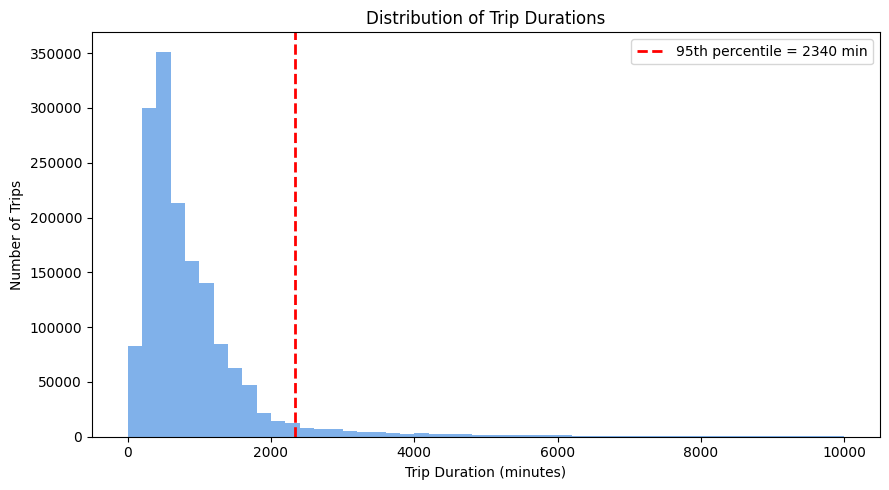

In [29]:
p95 = df_outliers["p95_duration"].iloc[0]

sql_durations = "SELECT duration FROM trips WHERE duration > 0 AND duration < 10000;"
df_durations = run_sql(sql_durations)

plt.figure(figsize=(9,5))
plt.hist(df_durations["duration"], bins=50, color="#4a90e2", alpha=0.7)
plt.axvline(p95, color="red", linestyle="--", linewidth=2, label=f"95th percentile = {p95:.0f} min")
plt.title("Distribution of Trip Durations")
plt.xlabel("Trip Duration (minutes)")
plt.ylabel("Number of Trips")
plt.legend()
plt.tight_layout()
plt.show()

 Distribution of trip durations, showing a long right tail with the 95th percentile marked at 2,340 minutes.

### 9.3 Interpretation
Most trips are relatively short, with an average of **~915 minutes,** but a small fraction extend far beyond this range, forming a pronounced **right-skewed tail.** These unusually long durations likely represent **leisure rides, stalled trips, or data entry errors,** and may require additional filtering or treatment in future analyses.

## Conclusion

This analysis reveals distinct ridership patterns: rapid early growth, strong weekday commuter peaks, and clear seasonal variation in trip duration. Central stations such as South Station and Boston Public Library dominate both trip starts and ends, with directional imbalances highlighting the need for periodic bike rebalancing. Registered users show higher activity and repeat rates, reflecting routine commuting, while casual users take fewer but longer leisure rides.

Future analysis could incorporate weather, time of day, and demographic data to build predictive models of demand and improve bike availability across the network.